<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/06-common-design-building-blocks/01_better_activation_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Better activation functions

We will discuss five new methods that work for feed-forward models and
one new improvement to RNNs. We introduce the first five methods roughly in the
order that they were invented, as each tends to use the preceding techniques in their
design. 

Individually, they improve accuracy and speed up training; but combined, they
are greater than the sum of their parts.

1. Better activation function
2. Batch/Layer normalization
3. Skip connections and 1 x 1 convolution
4. Residual connections
5. Long short-term memory (LSTM) layer

##Setup

In [ ]:
from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.metrics import accuracy_score

import time

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from idlmam import train_network, Flatten, weight_reset, set_seed
from idlmam import LanguageNameDataset, pad_and_pack, EmbeddingPackable, LastTimeStep, LambdaLayer

In [ ]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

torch.backends.cudnn.deterministic=True
set_seed(42)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##Dataset

We use the
Fashion-MNIST dataset because it is slightly more challenging while retaining the same
size and shape as the original MNIST corpus, which will let us accomplish some testing
in a reasonable time.

In [ ]:
B = 128

train_data = torchvision.datasets.FashionMNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.FashionMNIST("./data", train=True, transform=transforms.ToTensor(), download=True)

training_loader = DataLoader(train_data, batch_size=B, shuffle=True)
testing_loader = DataLoader(test_data, batch_size=B)

##Baseline model

##Optuna trail object

Optuna figures out how many hyperparameters exist by means of us using the trial
object to obtain a guess for each parameter. This happens with the suggest_uniform
function, which requires us to provide a range of possible values.

In [ ]:
def toy_func(trial):
  # The below two calls ask optuna for two parameters, and definethe minimum and maximum value for each one
  x = trial.suggest_uniform("x", -10.0, 10.0)
  y = trial.suggest_uniform("y", -10.0, 10.0)
  # Now we can compute and return the result. Optuna will try to minimize this value
  return abs((x - 3) * (y + 2))

Now we can use the `create_study` function to build the task
and call optimize with the number of trials we want to let Optuna have to minimize
the function.

In [ ]:
# If you said direction='maximize' Optuna would try and maximize the value returned by toy_func
study = optuna.create_study(direction="minimize")
# We tell Optuna which function to minimize, and that it gets 100 attempts to do so
study.optimize(toy_func, n_trials=100)

We can access true answer using `study.best_params`, which contains a dict
object mapping the hyperparameters to the values that, in combination, gave the best result.

In [ ]:
print(study.best_params)

{'x': 3.0505130497576554, 'y': -1.653112134896916}


We can use a contour plot to see an example.

In [ ]:
optuna.visualization.plot_contour(study)

##Optuna with PyTorch

We do not want to go crazy, as optimizing without any
gradients is still very difficult and Optuna is not a magic bullet. But we can use Optuna
to help us make some decisions. 

For example, how many neurons should we have in
each layer, and how many layers?

1. Create train/validation splits
2. Ask Optuna to give us three critical hyperparameters
3. Define our model using the parameters
4. Compute and return the result from the validation split

In [ ]:
def objective(trial):
  train_subset = int(len(train_data) * 0.8)
  test_subset = len(train_data) - train_subset 

  split = torch.utils.data.random_split(train_data, [train_subset, test_subset])

  train_loader = DataLoader(split[0], batch_size=B, shuffle=True)
  val_loader = DataLoader(split[1], batch_size=B, shuffle=False)

  # search hidden layer size
  n = trial.suggest_int("neurons_per_layer", 16, 256)
  layers = trial.suggest_int("hidden_layers", 1, 6)

  #How many values are in the input?
  D = 28*28 #28 * 28 images
  # How many channels are in the input?
  C = 1
  # How many classes are there?
  classes = 10

  # At least one hidden layer, that take in D inputs
  sequential_layers = [
    nn.Flatten(),
    nn.Linear(D, n),
    nn.Tanh()
  ]

  # Now lets add in a variable number of hidden layers, depending on what Optuna gave us for the "layers" parameter
  for _ in range(layers - 1):
    sequential_layers.append(nn.Linear(n, n))
    sequential_layers.append(nn.Tanh())

  # Output layer
  sequential_layers.append(nn.Linear(n, classes))

  # Now turn the list of layers into a PyTorch Sequential Module 
  fc_model = nn.Sequential(*sequential_layers)

  # What should our global learning rate be? Notice that we can ask for new hyper-parameters from optuna whenever we want
  eta_global = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)

  optimizer = torch.optim.AdamW(fc_model.parameters(), lr=eta_global)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs // 3)
  loss_func = nn.CrossEntropyLoss()

  results = train_network(fc_model, 
                          loss_func, 
                          train_loader,
                          epochs=10, 
                          test_loader=val_loader,
                          optimizer=optimizer,
                          lr_schedule=scheduler,
                          score_funcs={"Accuracy": accuracy_score},
                          device=device,
                          disable_tqdm=True)
  # A objective value linked with the Trial object
  return results["test Accuracy"].iloc[-1]

You must remember that this is a validation split and that we have not used
the test set. We should only use the test set after the hyperparameters have been found, to determine the overall accuracy.

Let's searches for the hyperparameters
for this problem.

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

In [ ]:
print(study.best_params)

{'neurons_per_layer': 188, 'hidden_layers': 1, 'learning_rate': 0.009184554219247697}


Let's look at the progress Optuna made
over time and other views of the optimization process. 

Doing so can help us build some
intuition about the range of “good” parameters.

In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

We might also want to get an idea of how each hyperparameter performs with respect
to the objective (accuracy). That can be done with a slice plot.

In [ ]:
fig = optuna.visualization.plot_slice(study)
fig.show()

Optuna can also help you understand the interactions between hyperparameters. One
option is the `plot_contour()` function, which creates a grid showing how every combination
of two different hyperparameters impacts the results.

In [ ]:
fig = optuna.visualization.plot_contour(study, params=["neurons_per_layer", "hidden_layers", "learning_rate"])
fig.show()

The other option is the
`plot_parallel_coordinate()` function, which shows all the results of every trial in one graph.

In [ ]:
fig = optuna.visualization.plot_parallel_coordinate(study, params=["neurons_per_layer", "hidden_layers", "learning_rate"])
fig.show()

Now that we have trained our network, so we need to train a new model with this information to determine what final
validation accuracy you get on the true validation set.

In [ ]:
D = 28 * 28       # input size
n = 188           # Hidden layer size
C= 1              # How many channels are in the input?
classes = 10      # How many classes are there?

# {'neurons_per_layer': 188, 'hidden_layers': 1, 'learning_rate': 0.009184554219247697}

In [ ]:
fc_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D, n),
    nn.Tanh(),
    nn.Linear(n, n),
    nn.Tanh(),
    nn.Linear(n, classes)
)

In [ ]:
eta_0 = 0.0091
loss_func = nn.CrossEntropyLoss()

fc_results = train_network(fc_model, 
                          loss_func, 
                          training_loader,
                          epochs=epochs, 
                          test_loader=testing_loader,
                          optimizer=torch.optim.SGD(fc_model.parameters(), lr=eta_0),
                          checkpoint_file="model.pt",
                          score_funcs={"Acc": accuracy_score},
                          device=device)

In [ ]:
fc_results.head()

,epoch,total time,train loss,test loss,train Acc,test Acc
0,0,5.376148,1.911337,1.497075,0.493467,0.5895
1,1,12.118124,1.252498,1.085094,0.625050,0.6439
2,2,17.500884,0.975920,0.906203,0.672233,0.6756
3,3,22.891364,0.842025,0.809663,0.699717,0.7012
4,4,28.332964,0.764014,0.747706,0.727383,0.7242


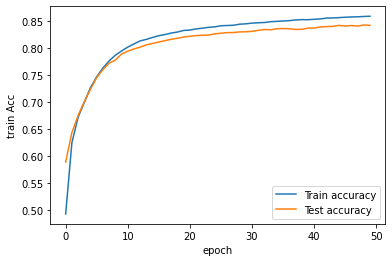

In [ ]:
sns.lineplot(x="epoch", y="train Acc", data=fc_results, label="Train accuracy")
sns.lineplot(x="epoch", y="test Acc", data=fc_results, label="Test accuracy")

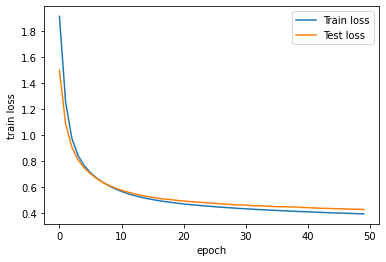

In [ ]:
sns.lineplot(x="epoch", y="train loss", data=fc_results, label="Train loss")
sns.lineplot(x="epoch", y="test loss", data=fc_results, label="Test loss")

As we show, the training and testing curve is very smooth, so now our network is not oscillating and overfitting.

##Pruning trials with Optuna

Optuna supports the feature that is particularly useful when training neural
networks is pruning trials early. 

The idea is that optimizing a neural network is iterative:
we take multiple epochs through the dataset, and we (hopefully) improve with every
epoch. This is valuable information we are not using. If we can determine early in the
process that a model won’t pan out, we can save a lot of time.

We can accomplish this by calling `train_network` 10 times in a loop for 1 epoch each.

In [ ]:
def objective_pruning(trial):
  train_subset = int(len(train_data) * 0.8)
  test_subset = len(train_data) - train_subset 

  split = torch.utils.data.random_split(train_data, [train_subset, test_subset])

  train_loader = DataLoader(split[0], batch_size=B, shuffle=True)
  val_loader = DataLoader(split[1], batch_size=B, shuffle=False)

  # search hidden layer size
  n = trial.suggest_int("neurons_per_layer", 16, 256)
  layers = trial.suggest_int("hidden_layers", 1, 6)

  #How many values are in the input?
  D = 28*28 #28 * 28 images
  # How many channels are in the input?
  C = 1
  # How many classes are there?
  classes = 10

  # At least one hidden layer, that take in D inputs
  sequential_layers = [
    nn.Flatten(),
    nn.Linear(D, n),
    nn.Tanh()
  ]

  # Now lets add in a variable number of hidden layers, depending on what Optuna gave us for the "layers" parameter
  for _ in range(layers - 1):
    sequential_layers.append(nn.Linear(n, n))
    sequential_layers.append(nn.Tanh())

  # Output layer
  sequential_layers.append(nn.Linear(n, classes))

  # Now turn the list of layers into a PyTorch Sequential Module 
  fc_model = nn.Sequential(*sequential_layers)

  # What should our global learning rate be? Notice that we can ask for new hyper-parameters from optuna whenever we want
  eta_global = trial.suggest_loguniform("learning_rate", 1e-6, 1e+2)

  optimizer = torch.optim.AdamW(fc_model.parameters(), lr=eta_global)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs // 3)
  loss_func = nn.CrossEntropyLoss()

  for epoch in range(10):
    results = train_network(fc_model, 
                            loss_func, 
                            train_loader,
                            epochs=1,             # Do just one epoch of training, but reuse the same model and optimizer
                            test_loader=val_loader,
                            optimizer=optimizer,
                            lr_schedule=scheduler,
                            score_funcs={"Accuracy": accuracy_score},
                            device=device,
                            disable_tqdm=True)
    # import pdb;pdb.set_trace()
    cur_accuracy = results["test Accuracy"].iloc[-1]
    # Lets Optuna know how well we are doing
    trial.report(cur_accuracy, epoch)

    # Asks Optuna if this looks hopeless
    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()   # If so, stop trying

  return cur_accuracy

I’m going to run a new trial with Optuna but intentionally set
the number of neurons to go down to 1 (way too small) and the learning rate to go
up to $\eta = 100$ (way too big). 

This will create some really bad models that are easy to
prune out, just to show off this new pruning feature.

In [ ]:
study2 = optuna.create_study(direction="maximize")
study2.optimize(objective_pruning, n_trials=20)   # n_trials=20 to give pruning more opportunities to occur

We can have Optuna plot the results of all
the trials with their intermediate values to help us understand that better.

In [ ]:
fig = optuna.visualization.plot_intermediate_values(study2)
fig.show()

It looks like all 10 trials were pruned after just 5 or 6 epochs through the dataset. That’s
very early in the process: Optuna has reduced the number of effective trials almost by half.

Early on, Optuna
lets bad models run to completion because it does not yet know they are bad models.
Only after more trials and seeing much better models does it learn that the original
ones could have been pruned. 

So pruning does not avoid all bad models, but it can
avoid many of them.

In [ ]:
print(study2.best_params)

{'neurons_per_layer': 118, 'hidden_layers': 1, 'learning_rate': 0.003523896765868023}


Now, let's train new model with these parameters.

In [ ]:
D = 28 * 28       # input size
n = 118           # Hidden layer size
C= 1              # How many channels are in the input?
classes = 10      # How many classes are there?

fc_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D, n),
    nn.Tanh(),
    nn.Linear(n, classes)
)

eta_0 = 0.00352
loss_func = nn.CrossEntropyLoss()

fc_results = train_network(fc_model, 
                          loss_func, 
                          training_loader,
                          epochs=epochs, 
                          test_loader=testing_loader,
                          optimizer=torch.optim.SGD(fc_model.parameters(), lr=eta_0),
                          checkpoint_file="model.pt",
                          score_funcs={"Acc": accuracy_score},
                          device=device)

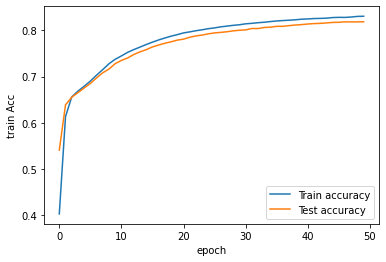

In [ ]:
sns.lineplot(x="epoch", y="train Acc", data=fc_results, label="Train accuracy")
sns.lineplot(x="epoch", y="test Acc", data=fc_results, label="Test accuracy")

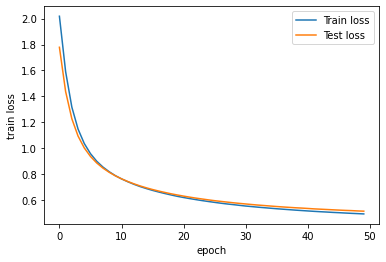

In [ ]:
sns.lineplot(x="epoch", y="train loss", data=fc_results, label="Train loss")
sns.lineplot(x="epoch", y="test loss", data=fc_results, label="Test loss")

Again we show, the training and testing curve is very smooth, so now our network is not oscillating and overfitting.